## **Tarea de Transfer Learning (entrenar una red)**

En este notebook se llevará acabo un entrenamiento de una red con transfer learning, en particular con **MobileNet V2** que es una red convolucional. El objetivo es lograr clasificar entre imágenes de caballos y humanos. La base de datos fue tomada de *kaggle*. 

Horses or Humans es un conjunto de datos de imágenes de 300 × 300, creado por Laurence Moroney. El conjunto contiene 500 imágenes renderizadas de varias especies de caballos en varias poses en varios lugares. También contiene 527 imágenes renderizadas de humanos en varias poses y ubicaciones. Se ha puesto énfasis en garantizar la diversidad de los seres humanos y, con ese fin, hay tanto hombres como mujeres, así como asiáticos, negros, sudasiáticos y caucásicos presentes en el conjunto de entrenamiento. El conjunto de validación agrega 6 figuras diferentes de diferente género, raza y poses para garantizar la amplitud de los datos.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-05-23 22:50:35.389251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 22:50:35.424957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 22:50:35.426063: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 22:50:36.055036: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## **Data Procesing**

In [7]:
# Ruta de la carpeta que contiene los datos descargados
data_dir = os.path.expanduser('~/Fisica Computacional 2/Transfer/archive/horse-or-human')

# Rutas de las carpetas de entrenamiento y validación
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')

# Parámetros para la carga de datos
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# Carga de los datos de entrenamiento
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1027 files belonging to 2 classes.


In [8]:
# Carga de los datos de validación
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 256 files belonging to 2 classes.


In [12]:
#Clases de la base de datos
class_names = train_dataset.class_names
print("Clases:", class_names)

Clases: ['horses', 'humans']


2023-05-23 23:32:17.738326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1027]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:32:17.738736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1027]
	 [[{{node Placeholder/_0}}]]


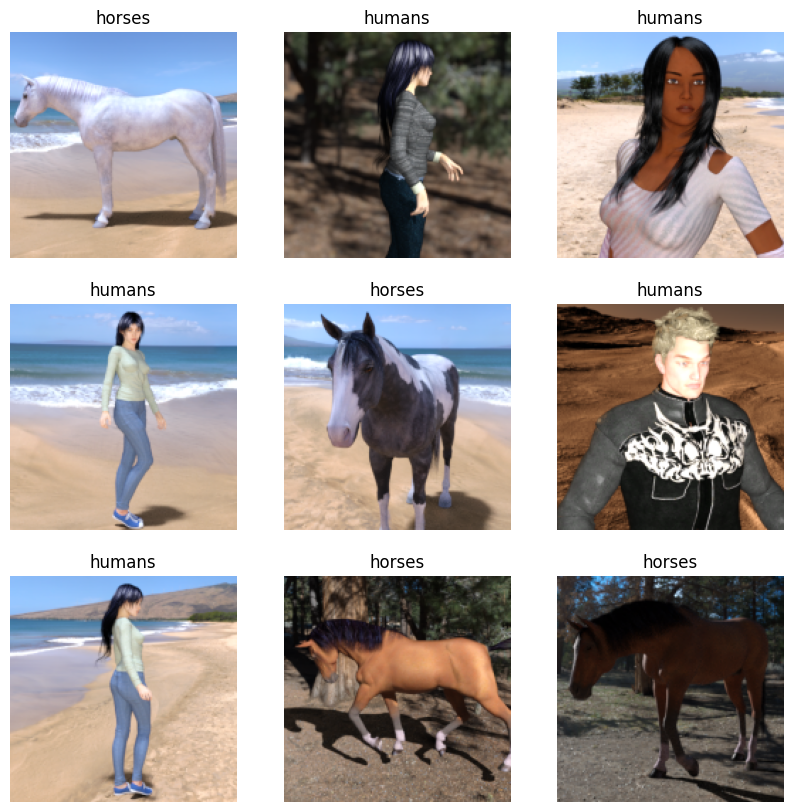

In [13]:
#Visualización de las imágenes
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Dado que la base de datos no contiene un conjunto de test, se debe de crear manualmente. En particular, se determinarán cuántos lotes de datos están disponibles en la validación y se moverá el $20\%$ de los datos al conjunto de test.

In [14]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [15]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 7
Number of test batches: 1


## **Configuración de los datos para un mejor rendimiento**

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Como no se tiene un conjunto de datos de imágenes grande, se lleva a cabo la aplicación de transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como la rotación horizontal. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento y reduce el sobreajuste.

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2023-05-23 23:42:37.521861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1027]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:42:37.522959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1027]
	 [[{{node Placeholder/_4}}]]


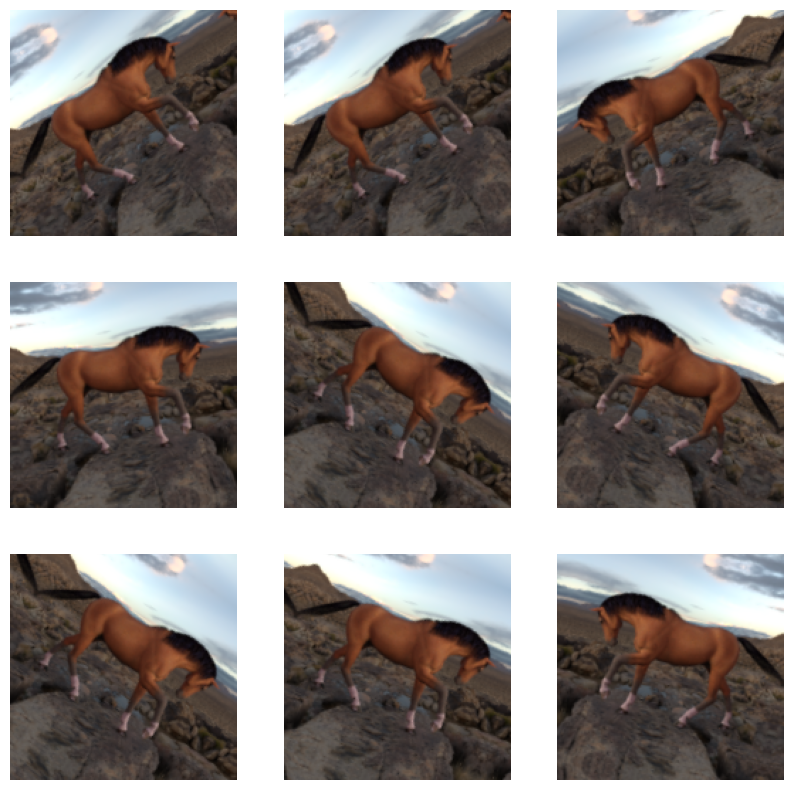

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

**Reescalamiento**

In [20]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [21]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## **Creando el modelo base a partir de MobilNet**

In [23]:
# Creación del modelo base a partir del modelo previamente entrenado MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 10s 1us/step


In [24]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-05-23 23:47:30.886971: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2023-05-23 23:47:30.927174: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2023-05-23 23:47:30.967956: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.
2023-05-23 23:47:31.013117: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 80621568 exceeds 10% of free system memory.


(32, 5, 5, 1280)


## **Extracción de Características**

In [25]:
base_model.trainable = False

In [26]:
#Arquitectura del modelo base
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [27]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [28]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [29]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [30]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [32]:
len(model.trainable_variables)

2

## **Entrenando el modelo**

In [33]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

2023-05-23 23:52:26.496064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [256]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:52:26.496409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [256]
	 [[{{node Placeholder/_0}}]]
2023-05-23 23:52:27.555302: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 78643200 exceeds 10% of free system memory.


7/7 [==============================] - 4s 402ms/step - loss: 0.9725 - accuracy: 0.2321


In [34]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.97
initial accuracy: 0.23


In [35]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
33/33 [==============================] - 22s 588ms/step - loss: 0.8757 - accuracy: 0.4567 - val_loss: 0.7940 - val_accuracy: 0.3973
Epoch 2/10
33/33 [==============================] - 21s 642ms/step - loss: 0.7048 - accuracy: 0.5920 - val_loss: 0.6385 - val_accuracy: 0.6518
Epoch 3/10
33/33 [==============================] - 24s 732ms/step - loss: 0.5945 - accuracy: 0.6748 - val_loss: 0.5333 - val_accuracy: 0.7545
Epoch 4/10
33/33 [==============================] - 25s 738ms/step - loss: 0.5086 - accuracy: 0.7264 - val_loss: 0.4387 - val_accuracy: 0.8348
Epoch 5/10
33/33 [==============================] - 25s 752ms/step - loss: 0.4288 - accuracy: 0.7868 - val_loss: 0.3766 - val_accuracy: 0.8929
Epoch 6/10
33/33 [==============================] - 25s 737ms/step - loss: 0.3525 - accuracy: 0.8520 - val_loss: 0.3142 - val_accuracy: 0.9464
Epoch 7/10
33/33 [==============================] - 25s 738ms/step - loss: 0.3177 - accuracy: 0.8754 - val_loss: 0.2678 - val_accuracy: 0.9821

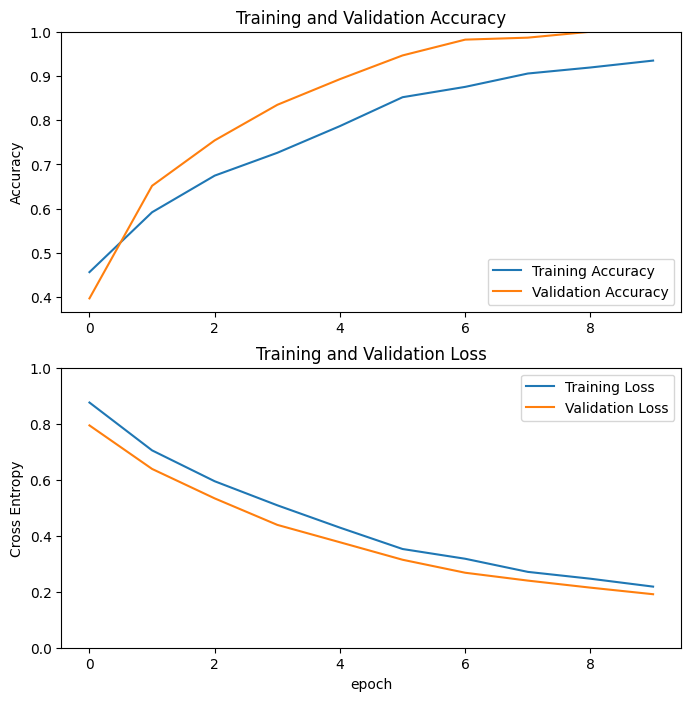

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Ya que el **accuaracy** alcanzo el valor máximo, el ajuste fino para este moedelo se omitira.

## **Evaluación y Predicción**

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2023-05-24 00:00:13.091046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [256]
	 [[{{node Placeholder/_4}}]]
2023-05-24 00:00:13.091903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [256]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 1s 523ms/step - loss: 0.2054 - accuracy: 1.0000
Test accuracy : 1.0


2023-05-24 00:00:58.692164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [32,160,160,3]
	 [[{{node Placeholder/_0}}]]


Predictions:
 [0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1]
Labels:
 [0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1]


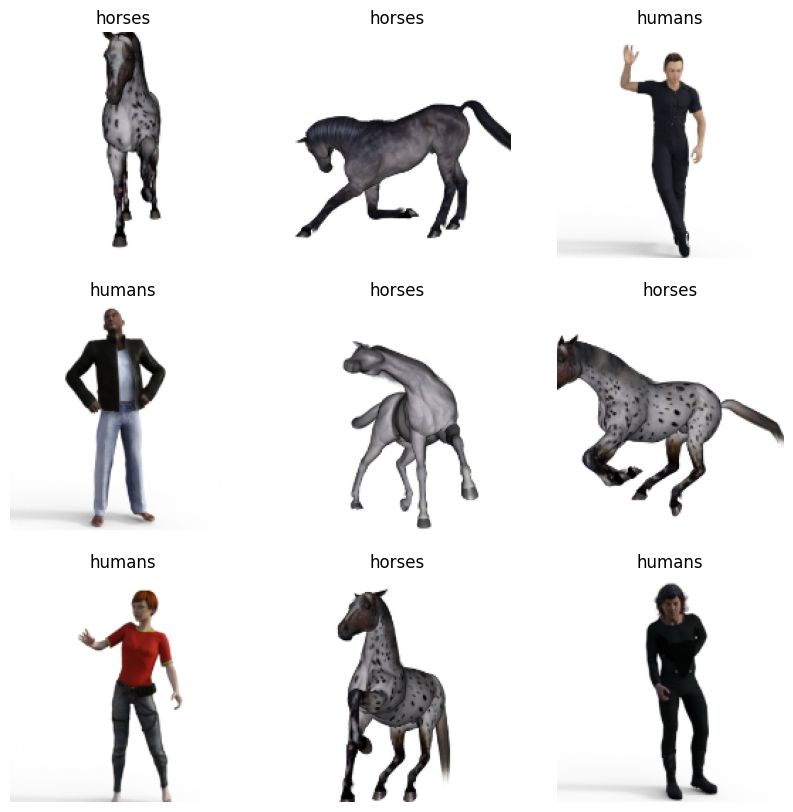

In [38]:
# Recuperar un lote de imágenes del conjunto de prueba
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Aplicar un sigmoide ya que el modelo devuelve logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")